# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Откройте файл с данными и изучите общую информацию. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')

In [3]:
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


In [4]:
data.columns

Index(['total_images', 'last_price', 'total_area', 'first_day_exposition',
       'rooms', 'ceiling_height', 'floors_total', 'living_area', 'floor',
       'is_apartment', 'studio', 'open_plan', 'kitchen_area', 'balcony',
       'locality_name', 'airports_nearest', 'cityCenters_nearest',
       'parks_around3000', 'parks_nearest', 'ponds_around3000',
       'ponds_nearest', 'days_exposition'],
      dtype='object')

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

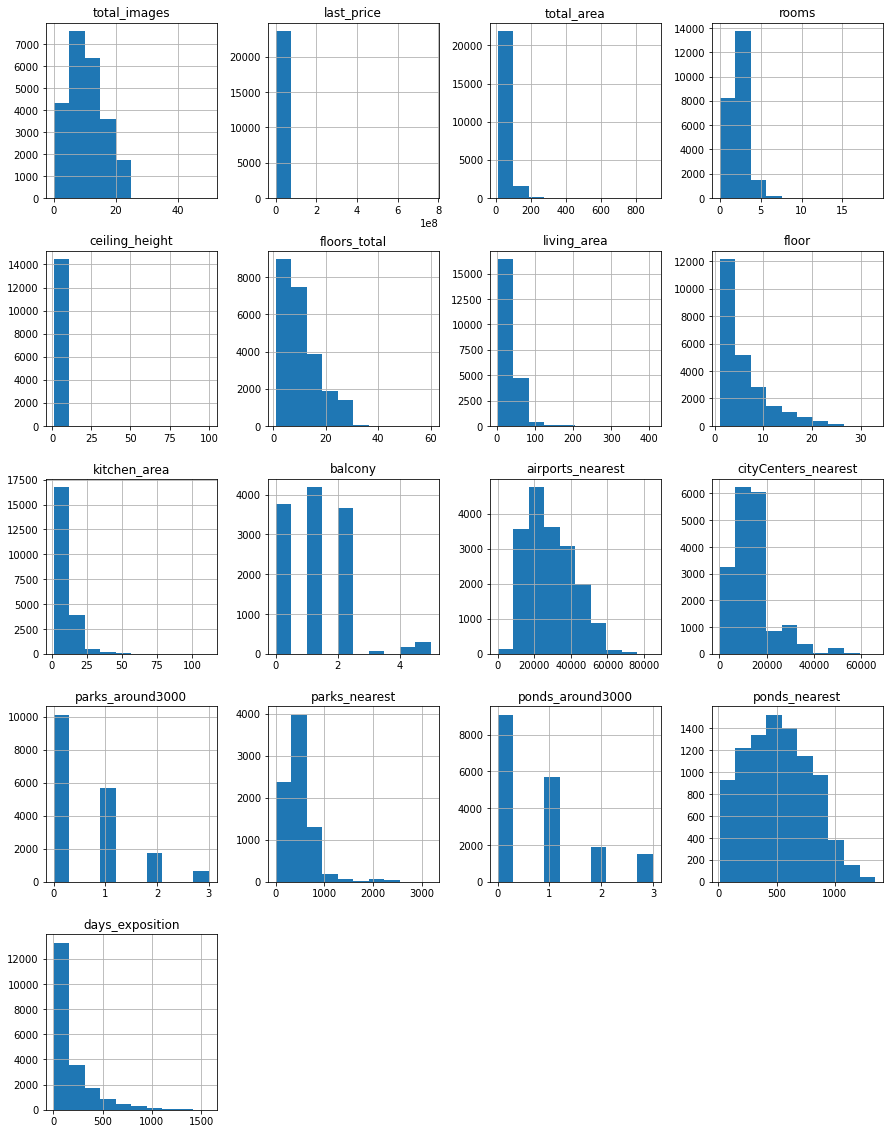

In [6]:
data.hist(figsize=(15, 20));

Вывод: Датасет загружен. Диаграммы построены, есть несколько необычных.

### Предобработка данных

#### 

In [7]:
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

In [8]:

data.isna().mean().round(4).to_frame().sort_values(by=0).style.format('{:.2%}').background_gradient('coolwarm')

,0
total_images,0.00%
open_plan,0.00%
floor,0.00%
rooms,0.00%
studio,0.00%
total_area,0.00%
last_price,0.00%
first_day_exposition,0.00%
locality_name,0.21%
floors_total,0.36%


Медиана не поменялась! Поэтому заменим пропущенные значения на изначальную медиану. 

In [9]:
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer

In [10]:
x=data[['total_area', 'living_area', 'kitchen_area', 'cityCenters_nearest', 'airports_nearest', 'ceiling_height']].copy(deep=True)
imputer = KNNImputer(n_neighbors=10, weights='uniform')
imputer.fit(x)
x1 = imputer.transform(x)
not_nan_data = pd.DataFrame(x1, columns=x.columns)
not_nan_data

,total_area,living_area,kitchen_area,cityCenters_nearest,airports_nearest,ceiling_height
0,108.00,51.000,25.00,16028.0,18863.0,2.70
1,40.40,18.600,11.00,18603.0,12817.0,2.59
2,56.00,34.300,8.30,13933.0,21741.0,2.57
3,159.00,86.910,28.37,6800.0,28098.0,3.08
4,100.00,32.000,41.00,8098.0,31856.0,3.03
...,...,...,...,...,...,...
23694,133.81,73.300,13.83,4232.0,24665.0,3.70
23695,59.00,38.000,8.50,11139.9,30032.5,2.81
23696,56.70,29.700,9.01,15596.0,28411.5,2.71
23697,76.75,38.054,23.30,10364.0,39140.0,3.00


Проверим есть ли нулевые значения


In [11]:
not_nan_data.isnull().sum()

total_area             0
living_area            0
kitchen_area           0
cityCenters_nearest    0
airports_nearest       0
ceiling_height         0
dtype: int64

Построим диаграммы, чтобы удостовериться, что пропуски были заполнены правильно

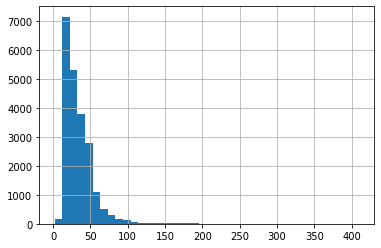

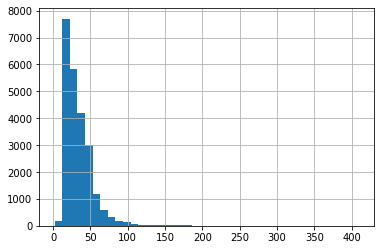

In [12]:
plt.show(data['living_area'].hist(bins=40))
plt.show(not_nan_data['living_area'].hist(bins=40))

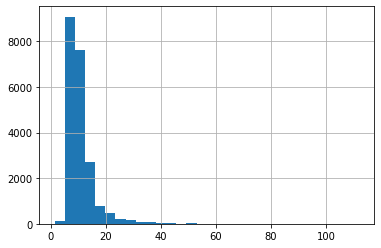

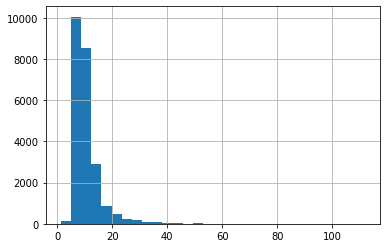

In [13]:
plt.show(data['kitchen_area'].hist(bins=30))
plt.show(not_nan_data['kitchen_area'].hist(bins=30))

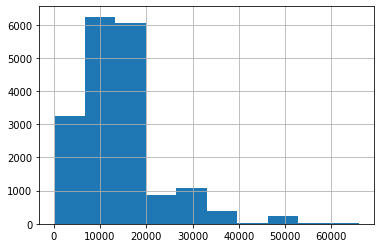

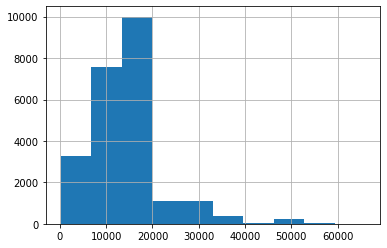

In [14]:
plt.show(data['cityCenters_nearest'].hist())
plt.show(not_nan_data['cityCenters_nearest'].hist())

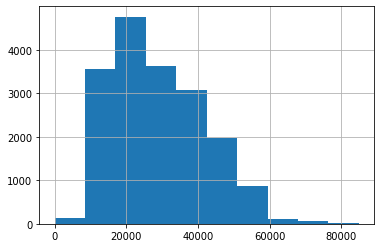

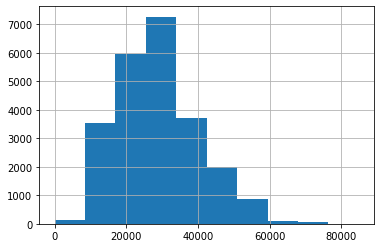

In [15]:
plt.show(data['airports_nearest'].hist())
plt.show(not_nan_data['airports_nearest'].hist())

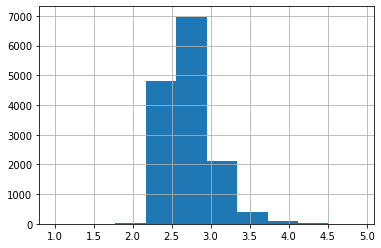

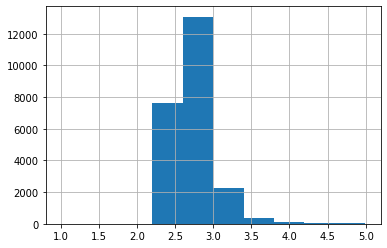

In [16]:
plt.show(data.query('ceiling_height < 5')['ceiling_height'].hist())
plt.show(not_nan_data.query('ceiling_height < 5')['ceiling_height'].hist())

<div class="alert alert-info">Как мы видимо пропуски заполнены в соответствии с распределением в оригинальном датасете ,поэтому можно их заменить там. </div>

In [17]:
data['living_area'] = not_nan_data['living_area']
data['kitchen_area'] = not_nan_data['kitchen_area']
data['airports_nearest'] = not_nan_data['airports_nearest']
data['cityCenters_nearest'] = not_nan_data['cityCenters_nearest']
data['ceiling_height'] = not_nan_data['ceiling_height']

In [18]:
data.isna().mean().round(4).to_frame().sort_values(by=0).style.format('{:.2%}').background_gradient('coolwarm')

,0
total_images,0.00%
cityCenters_nearest,0.00%
airports_nearest,0.00%
kitchen_area,0.00%
open_plan,0.00%
floor,0.00%
living_area,0.00%
studio,0.00%
ceiling_height,0.00%
rooms,0.00%


In [19]:
data['floors_total'].describe()

count    23613.000000
mean        10.673824
std          6.597173
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         60.000000
Name: floors_total, dtype: float64

Пропущенных значений мало, медиана = 9, хорошее значение для замены.

In [20]:
data['floors_total'] = data['floors_total'].fillna(data['floors_total'].median())

In [21]:
data['floors_total'].isna().sum()

0

In [22]:
data['is_apartment'] = data['is_apartment'].fillna(False)
data['is_apartment'].isna().sum()

0

В столбце "is_apartment" все пропущенные значения заменяем на False, так как люди просто пропускали вопрос и не заполняли эту строку, если они живут не в апартаментах.

In [23]:
data['balcony'].unique()

array([nan,  2.,  0.,  1.,  5.,  4.,  3.])

У кого нет балконов не заполнял поле, поэтому пишем 0.

In [24]:
data['balcony'] = data['balcony'].fillna(0)
data['balcony'].isna().sum()

0

In [25]:
data['locality_name'].unique()

array(['Санкт-Петербург', 'посёлок Шушары', 'городской посёлок Янино-1',
       'посёлок Парголово', 'посёлок Мурино', 'Ломоносов', 'Сертолово',
       'Петергоф', 'Пушкин', 'деревня Кудрово', 'Коммунар', 'Колпино',
       'поселок городского типа Красный Бор', 'Гатчина', 'поселок Мурино',
       'деревня Фёдоровское', 'Выборг', 'Кронштадт', 'Кировск',
       'деревня Новое Девяткино', 'посёлок Металлострой',
       'посёлок городского типа Лебяжье',
       'посёлок городского типа Сиверский', 'поселок Молодцово',
       'поселок городского типа Кузьмоловский',
       'садовое товарищество Новая Ропша', 'Павловск',
       'деревня Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп',
       'Приозерск', 'Сестрорецк', 'деревня Куттузи', 'посёлок Аннино',
       'поселок городского типа Ефимовский', 'посёлок Плодовое',
       'деревня Заклинье', 'поселок Торковичи', 'поселок Первомайское',
       'Красное Село', 'посёлок Понтонный', 'Сясьстрой', 'деревня Старая',
       'деревня Лесколово', '

Не будем заменять 49 пропусков в "locality_name", так как нет логичной замены

In [26]:
data['parks_around3000'].unique()

array([ 1.,  0.,  2., nan,  3.])

In [27]:
data['parks_around3000'] = data['parks_around3000'].fillna(0)
data['parks_around3000'].isna().sum()

0

<AxesSubplot:>

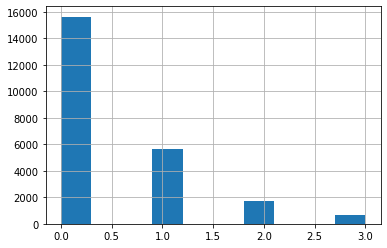

In [28]:
data['parks_around3000'].hist()

In [29]:
data['parks_nearest'].describe()

count    8079.000000
mean      490.804555
std       342.317995
min         1.000000
25%       288.000000
50%       455.000000
75%       612.000000
max      3190.000000
Name: parks_nearest, dtype: float64

In [30]:
data['ponds_around3000'].unique()

array([ 2.,  0.,  3.,  1., nan])

In [31]:
data['ponds_around3000'] = data['ponds_around3000'].fillna(0)
data['ponds_around3000'].isna().sum()

0

<AxesSubplot:>

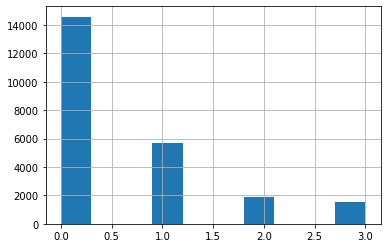

In [32]:
data['ponds_around3000'].hist()

In [33]:
data['ponds_nearest'].describe()

count    9110.000000
mean      517.980900
std       277.720643
min        13.000000
25%       294.000000
50%       502.000000
75%       729.000000
max      1344.000000
Name: ponds_nearest, dtype: float64

С картографическими данными, есть проблема - слишком  много пропусков, возможно это какая то ошибка или проблема в передаче/выгрузке данных. Заменять пропущенные 'ponds_nearest' и 'parks_nearest' медианой будет ошибкой, так как вряд ли у 15000 человек парк и водоём находятся ровно в 3км от дома. По гистограмме вижно что у абсолютного большинства нет рядом водоёма или парка. Поэтому заменить данные значения конкретным числом не получится. Оставим эти пропуски.

In [34]:
data['days_exposition'].describe()

count    20518.000000
mean       180.888634
std        219.727988
min          1.000000
25%         45.000000
50%         95.000000
75%        232.000000
max       1580.000000
Name: days_exposition, dtype: float64

In [35]:
data['days_exposition'].head(20)

0       NaN
1      81.0
2     558.0
3     424.0
4     121.0
5      55.0
6     155.0
7       NaN
8     189.0
9     289.0
10    137.0
11      7.0
12     90.0
13    366.0
14    203.0
15     19.0
16    397.0
17    571.0
18    168.0
19     97.0
Name: days_exposition, dtype: float64

Не будем заменять пропуски в "days_exposition" так как скорее всего эти квартиры просто ещё не продали

#### 


In [36]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        23699 non-null  float64
 6   floors_total          23699 non-null  float64
 7   living_area           23699 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          23699 non-null  bool   
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          23699 non-null  float64
 13  balcony               23699 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

исходя из этой таблицы нужно поменять тип данных в "floors_total", "balcony", "parks_around3000", "ponds_around3000" поскольку количество этажей, дней и балконов, парков и водоёмов не может быть нецелочисленным значением.

'last_price' тоже сделаем целочисленной, потому что так будет удобнее считать и воспронимать информацию.

In [37]:
data['floors_total'] = data['floors_total'].astype(int)
data['balcony'] = data['balcony'].astype(int)
data['ponds_around3000'] = data['ponds_around3000'].astype(int)
data['parks_around3000'] = data['parks_around3000'].astype(int)
data['last_price'] = data['last_price'].astype(int)

In [38]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  int64  
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        23699 non-null  float64
 6   floors_total          23699 non-null  int64  
 7   living_area           23699 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          23699 non-null  bool   
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          23699 non-null  float64
 13  balcony               23699 non-null  int64  
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

#### 


In [39]:
data['locality_name'].unique()

array(['Санкт-Петербург', 'посёлок Шушары', 'городской посёлок Янино-1',
       'посёлок Парголово', 'посёлок Мурино', 'Ломоносов', 'Сертолово',
       'Петергоф', 'Пушкин', 'деревня Кудрово', 'Коммунар', 'Колпино',
       'поселок городского типа Красный Бор', 'Гатчина', 'поселок Мурино',
       'деревня Фёдоровское', 'Выборг', 'Кронштадт', 'Кировск',
       'деревня Новое Девяткино', 'посёлок Металлострой',
       'посёлок городского типа Лебяжье',
       'посёлок городского типа Сиверский', 'поселок Молодцово',
       'поселок городского типа Кузьмоловский',
       'садовое товарищество Новая Ропша', 'Павловск',
       'деревня Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп',
       'Приозерск', 'Сестрорецк', 'деревня Куттузи', 'посёлок Аннино',
       'поселок городского типа Ефимовский', 'посёлок Плодовое',
       'деревня Заклинье', 'поселок Торковичи', 'поселок Первомайское',
       'Красное Село', 'посёлок Понтонный', 'Сясьстрой', 'деревня Старая',
       'деревня Лесколово', '

In [40]:
len(data['locality_name'].unique())

365

In [41]:
for elem in data['locality_name'].unique():
    if 'Янино' in str(elem):
        print(elem)

городской посёлок Янино-1
городской поселок Янино-1


In [42]:
data.loc[data['locality_name'] == 'городской посёлок Янино-1', 'locality_name'] = 'городской поселок Янино-1'

In [43]:
for elem in data['locality_name'].unique():
    if 'Мурин' in str(elem):
        print(elem)

посёлок Мурино
поселок Мурино
Мурино


In [44]:
# код ревьюера
data['locality_name'] = data['locality_name'].str.replace('ё', 'е', regex=True)

In [45]:
data.loc[(data['locality_name'] == 'посёлок Мурино'), 'locality_name'] = 'Мурино'
data.loc[(data['locality_name'] == 'поселок Мурино'), 'locality_name'] = 'Мурино'

In [46]:
for elem in data['locality_name'].unique():
    if 'Кудрово' in str(elem):
        print(elem)

деревня Кудрово
Кудрово


In [47]:
data.loc[(data['locality_name'] == 'деревня Кудрово'), 'locality_name'] = 'Кудрово'

In [48]:
for elem in data['locality_name'].unique():
    if 'Красный Бор' in str(elem):
        print(elem)

поселок городского типа Красный Бор


In [49]:
data.loc[(data['locality_name'] == 'посёлок городского типа Красный Бор'), 'locality_name'] = 'поселок городского типа Красный Бор'

In [50]:
for elem in data['locality_name'].unique():
    if 'Фёдоровское' in str(elem):
        print(elem)

In [51]:
data.loc[(data['locality_name'] == 'деревня Фёдоровское'), 'locality_name'] = 'городской посёлок Фёдоровское'

In [52]:
poselok = []
for elem in data['locality_name'].unique():
    if 'поселок' in str(elem):
        poselok.append(elem.split()[-1])


In [53]:
posoeolok = []
for elem in data['locality_name'].unique():
    if 'посёлок' in str(elem):
        posoeolok.append(elem.split()[-1])

In [54]:
duplicat =[]
for elem in poselok:
    if elem in posoeolok:
        duplicat.append(elem)

In [55]:
for el in duplicat:
    for elem in data['locality_name'].unique():
        if el in str(elem):
            print(elem)
    print()

In [56]:
data.loc[(data['locality_name'] == 'посёлок Пансионат Зелёный Бор'), 'locality_name'] = 'поселок Пансионат Зелёный Бор'
data.loc[(data['locality_name'] == 'посёлок городского типа Кузьмоловский'), 'locality_name'] = 'поселок городского типа Кузьмоловский'
data.loc[(data['locality_name'] == 'посёлок Новый Свет'), 'locality_name'] = 'поселок Новый Свет'
data.loc[(data['locality_name'] == 'посёлок Бугры'), 'locality_name'] = 'поселок Бугры'
data.loc[(data['locality_name'] == 'посёлок городского типа Рощино'), 'locality_name'] = 'поселок городского типа Рощино'
data.loc[(data['locality_name'] == 'городской посёлок Рощино'), 'locality_name'] = 'поселок городского типа Рощино'
data.loc[(data['locality_name'] == 'посёлок Терволово'), 'locality_name'] = 'поселок Терволово'
data.loc[(data['locality_name'] == 'городской посёлок Советский'), 'locality_name'] = 'поселок городского типа Советский'
data.loc[(data['locality_name'] == 'посёлок городского типа Вырица'), 'locality_name'] = 'поселок городского типа Вырица'
data.loc[(data['locality_name'] == 'посёлок городского типа имени Свердлова'), 'locality_name'] = 'поселок городского типа имени Свердлова'
data.loc[(data['locality_name'] == 'поселок городского типа Рябово'), 'locality_name'] = 'поселок Рябово'
data.loc[(data['locality_name'] == 'посёлок городского типа Рябово'), 'locality_name'] = 'поселок Рябово'
data.loc[(data['locality_name'] == 'посёлок Ильичёво'), 'locality_name'] = 'поселок Ильичёво'
data.loc[(data['locality_name'] == 'посёлок при железнодорожной станции Вещево'), 'locality_name'] = 'поселок станции Вещево'
data.loc[(data['locality_name'] == 'посёлок Тельмана'), 'locality_name'] = 'поселок Тельмана'
data.loc[(data['locality_name'] == 'посёлок Старая Малукса'), 'locality_name'] = 'поселок Старая Малукса'
data.loc[(data['locality_name'] == 'посёлок Аннино'), 'locality_name'] = 'поселок Аннино'
data.loc[(data['locality_name'] == 'посёлок Победа'), 'locality_name'] = 'поселок Победа'
data.loc[(data['locality_name'] == 'посёлок Гаврилово'), 'locality_name'] = 'поселок Гаврилово'
data.loc[(data['locality_name'] == 'посёлок при железнодорожной станции Приветнинское'), 'locality_name'] = 'поселок станции Приветнинское'
data.loc[(data['locality_name'] == 'посёлок Поляны'), 'locality_name'] = 'поселок Поляны'
data.loc[(data['locality_name'] == 'посёлок Мельниково'), 'locality_name'] = 'поселок Мельниково'
data.loc[(data['locality_name'] == 'посёлок Стеклянный'), 'locality_name'] = 'поселок Стеклянный'
data.loc[(data['locality_name'] == 'посёлок городского типа Лебяжье'), 'locality_name'] = 'поселок городского типа Лебяжье'
data.loc[(data['locality_name'] == 'посёлок городского типа Форносово'), 'locality_name'] = 'поселок городского типа Форносово'
data.loc[(data['locality_name'] == 'посёлок Возрождение'), 'locality_name'] = 'поселок Возрождение'
data.loc[(data['locality_name'] == 'посёлок Лисий Нос'), 'locality_name'] = 'поселок Лисий Нос'
data.loc[(data['locality_name'] == 'посёлок Жилгородок'), 'locality_name'] = 'поселок Жилгородок'
data.loc[(data['locality_name'] == 'городской посёлок Лесогорский'), 'locality_name'] = 'поселок городского типа Лесогорский'
data.loc[(data['locality_name'] == 'посёлок Петровское'), 'locality_name'] = 'поселок Петровское'
data.loc[(data['locality_name'] == 'посёлок Мичуринское'), 'locality_name'] = 'поселок Мичуринское'
data.loc[(data['locality_name'] == 'посёлок городского типа Токсово'), 'locality_name'] = 'поселок городского типа Токсово'
data.loc[(data['locality_name'] == 'городской посёлок Назия'), 'locality_name'] = 'поселок городского типа Назия'
data.loc[(data['locality_name'] == 'посёлок Кобралово'), 'locality_name'] = 'поселок Кобралово'
data.loc[(data['locality_name'] == 'коттеджный посёлок Лесное'), 'locality_name'] = 'поселок Лесное'
data.loc[(data['locality_name'] == 'посёлок Усть-Луга'), 'locality_name'] = 'поселок Усть-Луга'
data.loc[(data['locality_name'] == 'посёлок Перово'), 'locality_name'] = 'поселок Перово'
data.loc[(data['locality_name'] == 'посёлок Коробицыно'), 'locality_name'] = 'поселок Коробицыно'
data.loc[(data['locality_name'] == 'посёлок Сумино'), 'locality_name'] = 'поселок Сумино'
data.loc[(data['locality_name'] == 'посёлок станции Громово'), 'locality_name'] = 'поселок Громово'

In [57]:
data['locality_name'].unique()

array(['Санкт-Петербург', 'поселок Шушары', 'городской поселок Янино-1',
       'поселок Парголово', 'Мурино', 'Ломоносов', 'Сертолово',
       'Петергоф', 'Пушкин', 'Кудрово', 'Коммунар', 'Колпино',
       'поселок городского типа Красный Бор', 'Гатчина',
       'деревня Федоровское', 'Выборг', 'Кронштадт', 'Кировск',
       'деревня Новое Девяткино', 'поселок Металлострой',
       'поселок городского типа Лебяжье',
       'поселок городского типа Сиверский', 'поселок Молодцово',
       'поселок городского типа Кузьмоловский',
       'садовое товарищество Новая Ропша', 'Павловск',
       'деревня Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп',
       'Приозерск', 'Сестрорецк', 'деревня Куттузи', 'поселок Аннино',
       'поселок городского типа Ефимовский', 'поселок Плодовое',
       'деревня Заклинье', 'поселок Торковичи', 'поселок Первомайское',
       'Красное Село', 'поселок Понтонный', 'Сясьстрой', 'деревня Старая',
       'деревня Лесколово', 'поселок Новый Свет', 'Сланцы',
   

In [58]:
for elem in data['locality_name'].unique():
    for el in data['locality_name'].unique():
        if str(elem).split()[-1] == str(el).split()[-1]:
            print(elem)

Санкт-Петербург
поселок Шушары
городской поселок Янино-1
поселок Парголово
Мурино
Ломоносов
Сертолово
Петергоф
Пушкин
Кудрово
Коммунар
Колпино
поселок городского типа Красный Бор
поселок городского типа Красный Бор
поселок городского типа Красный Бор
поселок городского типа Красный Бор
поселок городского типа Красный Бор
поселок городского типа Красный Бор
Гатчина
деревня Федоровское
деревня Федоровское
Выборг
Кронштадт
Кировск
деревня Новое Девяткино
поселок Металлострой
поселок городского типа Лебяжье
поселок городского типа Сиверский
поселок Молодцово
поселок городского типа Кузьмоловский
садовое товарищество Новая Ропша
садовое товарищество Новая Ропша
Павловск
деревня Пикколово
Всеволожск
Волхов
Кингисепп
Приозерск
Сестрорецк
деревня Куттузи
поселок Аннино
поселок городского типа Ефимовский
поселок Плодовое
деревня Заклинье
поселок Торковичи
поселок Первомайское
Красное Село
поселок Понтонный
Сясьстрой
деревня Старая
деревня Лесколово
поселок Новый Свет
Сланцы
село Путилово
Иванго

In [59]:
for elem in data['locality_name'].unique():
    if 'Романовка' in str(elem):
        print(elem)

поселок Романовка
деревня Малая Романовка


In [60]:
data.loc[(data['locality_name'] == 'село Никольское'), 'locality_name'] = 'Никольское'
data.loc[(data['locality_name'] == 'городской посёлок Павлово'), 'locality_name'] = 'посёлок городского типа Павлово'
data.loc[(data['locality_name'] == 'село Павлово'), 'locality_name'] = 'посёлок городского типа Павлово'
data.loc[(data['locality_name'] == 'городской поселок Большая Ижора'), 'locality_name'] = 'поселок городского типа Большая Ижора'
data.loc[(data['locality_name'] == 'городской посёлок Мга'), 'locality_name'] = 'посёлок городского типа Мга'



Все неявные дубликаты в 'locality_name' убраны. Можно проверить данные на явные дубликаты.

In [61]:
len(data['locality_name'].unique())

326


<div class="alert alert-info">Было 365  уникальных значений, стало 326 </div>

In [62]:
data.duplicated().sum()

0

Явных дубликатов нет

#### 


In [63]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  int64  
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        23699 non-null  float64
 6   floors_total          23699 non-null  int64  
 7   living_area           23699 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          23699 non-null  bool   
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          23699 non-null  float64
 13  balcony               23699 non-null  int64  
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

In [64]:
data['total_images'].unique()

array([20,  7, 10,  0,  2,  6,  5, 18,  9,  1, 16, 11,  8, 12, 13,  3, 15,
       17, 14, 19, 32,  4, 35, 39, 23, 21, 27, 30, 24, 25, 28, 31, 22, 29,
       26, 50, 42, 37])

Аномальных значений нет

In [65]:
print(data['last_price'].max())
print(data['last_price'].min())
print(data['last_price'].head(15))

763000000
12190
0     13000000
1      3350000
2      5196000
3     64900000
4     10000000
5      2890000
6      3700000
7      7915000
8      2900000
9      5400000
10     5050000
11     3300000
12     3890000
13     3550000
14     4400000
Name: last_price, dtype: int64


квартира за 763 миллиона весьма вероятна в Санкт-Петербурге, а вот квартира за 12 тысяч рублей выглядит как невозможное значение. Нужно посмотреть сколько квартир продаются за меньше чем 750 000 тысяч рублей

In [66]:
data.query('last_price < 750000').count()

total_images            89
last_price              89
total_area              89
first_day_exposition    89
rooms                   89
ceiling_height          89
floors_total            89
living_area             89
floor                   89
is_apartment            89
studio                  89
open_plan               89
kitchen_area            89
balcony                 89
locality_name           89
airports_nearest        89
cityCenters_nearest     89
parks_around3000        89
parks_nearest            1
ponds_around3000        89
ponds_nearest            0
days_exposition         76
dtype: int64

89 квартир, что не слишком влияет на данные, поэтому их  можно удалить

In [67]:
data = data.loc[data['last_price'] > 750000]

In [68]:
data['total_area'].describe()

count    23598.000000
mean        60.436962
std         35.697900
min         12.000000
25%         40.000000
50%         52.000000
75%         70.000000
max        900.000000
Name: total_area, dtype: float64

выбивающихся значений нет

In [69]:
data['rooms'].unique()

array([ 3,  1,  2,  4,  5,  6,  0,  7, 11,  8, 14, 10, 15,  9, 19, 16, 12])

0 комнат в квартире быть не может, поэтому тоже удалим эти значения

In [70]:
data.query('rooms == 0')['rooms'].count()

197

In [71]:
data = data.loc[data['rooms'] != 0]

In [72]:
data['ceiling_height'].describe()

count    23401.000000
mean         2.747124
std          1.006987
min          1.000000
25%          2.558000
50%          2.650000
75%          2.754000
max        100.000000
Name: ceiling_height, dtype: float64

In [73]:
data.query('ceiling_height < 1.8 or ceiling_height > 10')['ceiling_height']

355       25.000
3148      32.000
4643      25.000
5076      24.000
5246      27.000
5669      26.000
5712       1.200
5807      27.000
6246      25.000
9379      25.000
10773     27.000
11285     25.000
12985     12.497
14382     25.000
15061     14.000
16934      1.750
17496     20.000
17857     27.000
18545     25.000
20478     27.000
20507     22.600
21377     27.500
21824     27.000
22309     10.300
22336     32.000
22590      1.000
22869    100.000
22938     27.000
23097     12.472
Name: ceiling_height, dtype: float64

Удалим значения меньше 2 метров и 100 метров, а остальные значения разделим на 10

In [74]:
def div_by_10(height):
    if height > 10 and height != 100:
        return height / 10
    else:
        return height
data['ceiling_height'] = data['ceiling_height'].apply(div_by_10)

In [75]:
data = data.loc[(data['ceiling_height'] > 2) & (data['ceiling_height'] != 100)]

In [76]:
data.query('ceiling_height < 1.8 or ceiling_height > 10')['ceiling_height']

Series([], Name: ceiling_height, dtype: float64)

Аномальные значения в 'ceiling_height" либо изменены либо удалены

In [77]:
data['floors_total'].unique()

array([16, 11,  5, 14, 12, 26, 24, 27,  9,  6, 17, 25,  3, 23, 19, 18,  4,
       22,  8,  2, 10,  7, 13, 15, 20, 28, 36, 21, 35, 34, 60,  1, 29, 33,
       52])

Аномальных значений нет

In [78]:
data['living_area'].describe()

count    23381.000000
mean        34.693792
std         21.887721
min          2.000000
25%         18.900000
50%         30.099998
75%         42.500000
max        409.700000
Name: living_area, dtype: float64

2 квадратных метра слишком мало, для living area, нужно ограничить 5 метрами.

In [79]:
data.query('living_area < 5')['living_area'].count()

3

In [80]:
data = data.loc[(data['living_area'] > 5)]

In [81]:
data['floor'].unique()

array([ 8,  1,  4,  9, 13,  5,  6, 22, 26,  7,  3,  2, 11, 15, 18, 10, 19,
       16, 20, 27, 25, 17, 14, 12, 21, 28, 24, 23, 30, 29, 32, 33, 31])

Аномальных значений в "floor" нет

In [82]:
data['kitchen_area'].describe()

count    23378.000000
mean        10.537904
std          5.777593
min          1.300000
25%          7.100000
50%          9.180000
75%         12.000000
max        112.000000
Name: kitchen_area, dtype: float64

Предположим, что кухня может быть такой маленькой(1.3 кв. метра), поэтому здесь нет аномальных значений

In [83]:
data['balcony'].unique()

array([0, 2, 1, 5, 4, 3])

Аномальных значений в "balcony" нет

In [84]:
data['airports_nearest'].describe()

count    23378.000000
mean     28843.965947
std      11285.624101
min          0.000000
25%      20807.425000
50%      27838.000000
75%      35445.000000
max      84869.000000
Name: airports_nearest, dtype: float64

In [85]:
data.query('airports_nearest < 1000 ')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
21085,0,7000000,34.7,2018-09-23T00:00:00,1,2.7,9,19.8,3,False,...,6.0,2,Санкт-Петербург,0.0,22801.0,0,NaN,0,NaN,60.0


всего одно аномальное значение, удалим его

In [86]:
data = data.loc[data['airports_nearest'] != 0]

In [87]:
data['cityCenters_nearest'].describe()

count    23377.000000
mean     14387.189323
std       7703.372677
min        181.000000
25%      10660.000000
50%      13787.000000
75%      16453.000000
max      65968.000000
Name: cityCenters_nearest, dtype: float64

Аномальных значений в "cityCenters_nearest" нет

In [88]:
data['parks_around3000'].unique()

array([1, 0, 2, 3])

In [89]:
data['ponds_around3000'].unique()

array([2, 0, 3, 1])

In [90]:
data['ponds_nearest'].describe()

count    9033.000000
mean      518.038858
std       277.635897
min        13.000000
25%       294.000000
50%       502.000000
75%       730.000000
max      1344.000000
Name: ponds_nearest, dtype: float64

Аномальных значений нет, кто-то может жить прямо на берегу Невы

In [91]:
data['parks_nearest'].describe()

count    8042.000000
mean      490.364710
std       342.497317
min         1.000000
25%       287.250000
50%       453.500000
75%       612.000000
max      3190.000000
Name: parks_nearest, dtype: float64

Здесь та же история, жить в квартире, которая находится в парке Петербурга наверное можно.

Вывод по этапу: закончена предобработка данных. Заменены пропущенные значения(не все), изменены типы данных, заменены явные и неявные дубликаты, устранены редкие и выбивающиеся значения.

### Посчитайте и добавьте в таблицу новые столбцы

In [92]:
data['price_1_square_metr'] = data['last_price'] / data['total_area'] 

Изменим формат времени

In [93]:
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')

In [94]:
data['weekday_exposition'] = data['first_day_exposition'].dt.weekday
data['month_exposition'] = data['first_day_exposition'].dt.month
data['year_exposition'] = data['first_day_exposition'].dt.year

In [95]:
 def floor(row):
        if row['floor'] == 1:
            return 'первый'
        elif row['floor'] == row['floors_total']:
            return 'последний'
        else:
            return 'другой'
        

In [96]:
data['type_of_floor'] = data.apply(floor, axis=1)

In [97]:
data['city_center_km'] = (data['cityCenters_nearest'] / 1000).astype(int)

In [98]:
data.head(10)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_1_square_metr,weekday_exposition,month_exposition,year_exposition,type_of_floor,city_center_km
0,20,13000000,108.00,2019-03-07,3,2.700,16,51.00,8,False,...,482.0,2,755.0,NaN,120370.370370,3,3,2019,другой,16
1,7,3350000,40.40,2018-12-04,1,2.590,11,18.60,1,False,...,NaN,0,NaN,81.0,82920.792079,1,12,2018,первый,18
2,10,5196000,56.00,2015-08-20,2,2.570,5,34.30,4,False,...,90.0,2,574.0,558.0,92785.714286,3,8,2015,другой,13
3,0,64900000,159.00,2015-07-24,3,3.080,14,86.91,9,False,...,84.0,3,234.0,424.0,408176.100629,4,7,2015,другой,6
4,2,10000000,100.00,2018-06-19,2,3.030,14,32.00,13,False,...,112.0,1,48.0,121.0,100000.000000,1,6,2018,другой,8
5,10,2890000,30.40,2018-09-10,1,2.670,12,14.40,5,False,...,NaN,0,NaN,55.0,95065.789474,0,9,2018,другой,13
6,6,3700000,37.30,2017-11-02,1,2.613,26,10.60,6,False,...,NaN,0,NaN,155.0,99195.710456,3,11,2017,другой,19
7,5,7915000,71.60,2019-04-18,2,2.710,24,36.14,22,False,...,NaN,0,NaN,NaN,110544.692737,3,4,2019,другой,11
8,20,2900000,33.16,2018-05-23,1,2.575,27,15.43,26,False,...,NaN,0,NaN,189.0,87454.764777,2,5,2018,другой,15
9,18,5400000,61.00,2017-02-26,3,2.500,9,43.60,7,False,...,NaN,0,NaN,289.0,88524.590164,6,2,2017,другой,15


Вывод:Все необходимые столбцы добавлены в dataframe. 
"price_1_square_metr" - цена одного квадратного метра; 
"weekday_exposition" - день недели публикации объявления
"month_exposition" - месяц публикации объявления;
"year_exposition" - год публикации объявления;
"type_of_floor" - тип этажа квартиры
"city_center_km" - расстояние до центра города в километрах


### Проведите исследовательский анализ данных

#### 

<AxesSubplot:>

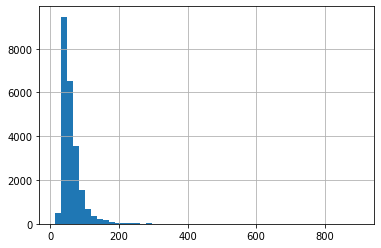

In [99]:
data['total_area'].hist(bins=50)

<AxesSubplot:>

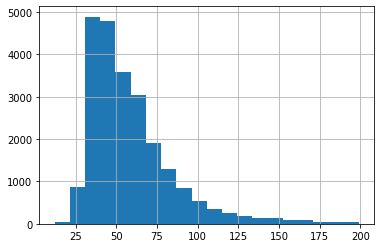

In [100]:
data.query('total_area < 200')['total_area'].hist(bins=20)

в 1 гистограмме слишком много выбросов, поэтому после ограничения площади в 200 кв. метров. данные можно рассмотреть подробнее. Абсолютное большинство квартир находятся в диапозоне 35 - 90 кв. метров, что логично.

<AxesSubplot:>

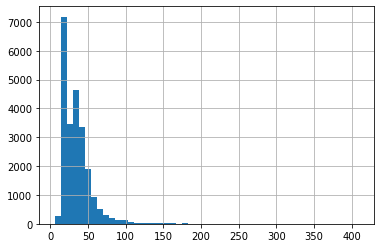

In [101]:
data['living_area'].hist(bins=50)

Здесь два пика 

<AxesSubplot:>

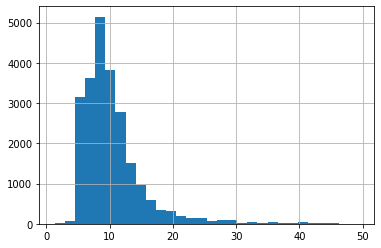

In [102]:
data.query('kitchen_area < 50')['kitchen_area'].hist(bins=30)

В целом нормальное распределение с длинным пиком примерно в 9 квадратных метрах

<AxesSubplot:>

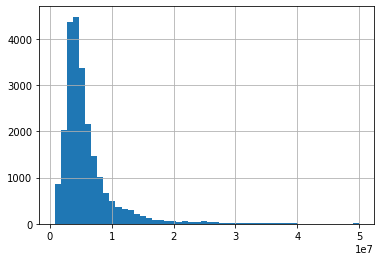

In [103]:
data.query('last_price < 50000000')['last_price'].hist(bins=50)

Ограничив цену 50млн мы получаем диаграмму с нормальным распредленнием

<AxesSubplot:>

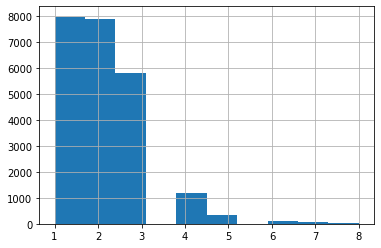

In [104]:
data.query('rooms < 9')['rooms'].hist()

В большинстве своём в квартирах 1,2 или 3 комнаты.

<AxesSubplot:>

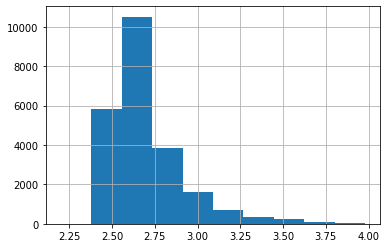

In [105]:
data.query('ceiling_height < 4')['ceiling_height'].hist()

Ярко выделяется видимо стандартная высота потолков(2.6 м), в остальном ничего необычного

<AxesSubplot:>

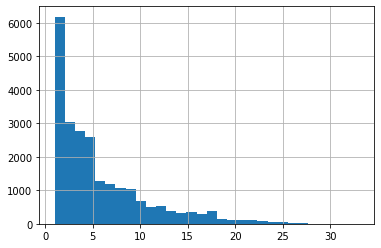

In [106]:
data['floor'].hist(bins=30)

Много людей продают квартиры на первом этаже, чем выше этаж тем меньше предложений квартир.

<AxesSubplot:>

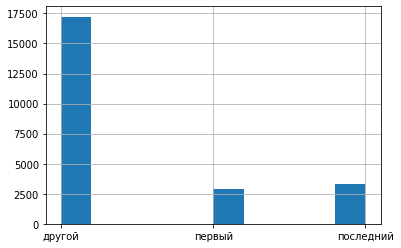

In [107]:
data['type_of_floor'].hist()

Оказывается практически одинаковое число людей продают квартиры на первом и на последнем этаже.

<AxesSubplot:>

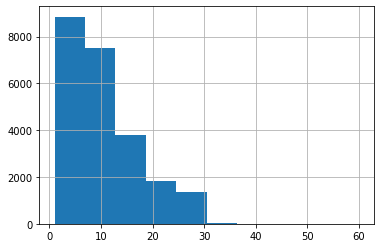

In [108]:
data['floors_total'].hist()

Также наблюдается тенденция снижения предложений по мере увеличения этажности дома 

<AxesSubplot:>

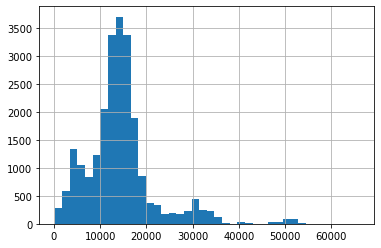

In [109]:
data['cityCenters_nearest'].hist(bins=40)

Большинство квартир находятся в диапазоне от 5 до 20 км от центра города. Распределение нормальное

<AxesSubplot:>

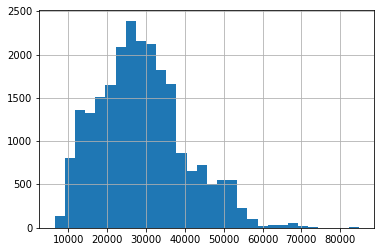

In [110]:
data['airports_nearest'].hist(bins=30)

Снова нормальное распредедение с длинным выделяющимся пиком примерно в 25-26 км от аэропорта

<AxesSubplot:>

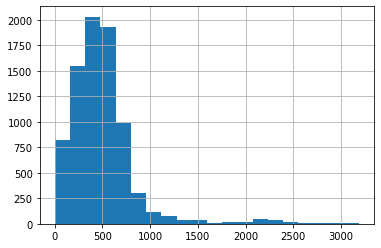

In [111]:
data['parks_nearest'].hist(bins=20)

Среди 8 тысяч предложений из 23 тысяч у большинства предложений парк находится в радиусе километра.


<AxesSubplot:>

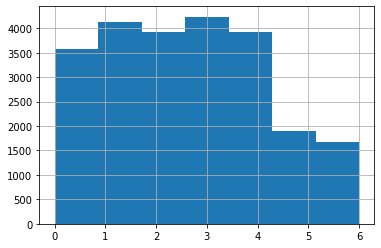

In [112]:
data['weekday_exposition'].hist(bins=7)

В выходные люди выкладывали меньше объявлений чем в будни, возможно это связано с тем, что некоторые объявления выкладывают агенства недвижимости, которые не работают в выходные.

<AxesSubplot:>

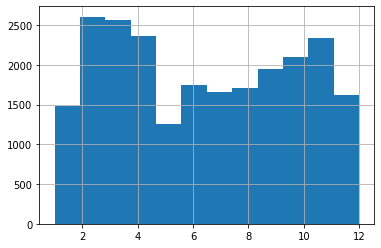

In [113]:
data['month_exposition'].hist(bins=12)

Больше всего обхявления выкладывают в феврале, марте, апреле и ноябре. Меньше всего в мае, декабре и январе.

#### 

<AxesSubplot:>

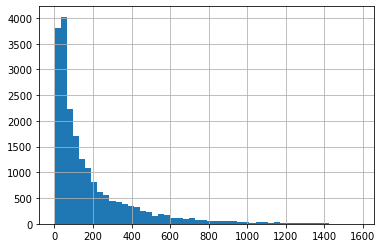

In [114]:
data['days_exposition'].hist(bins=50)

<AxesSubplot:>

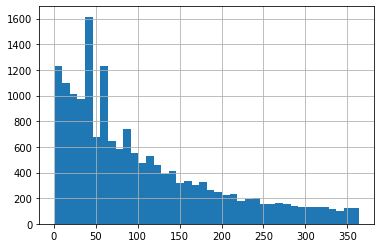

In [115]:
data.query('days_exposition < 365')['days_exposition'].hist(bins=40)

In [116]:
days_exposition_mean = data['days_exposition'].mean()
days_exposition_median = data['days_exposition'].median()
print('Среднее равно', days_exposition_mean.round(3))
print('Медиана равна', days_exposition_median)

Среднее равно 181.702
Медиана равна 96.0


На 2 гистограмме видно, что большинство квартир было продано в промежуток  от 0 до 100 дней. Так как мы замениил пропущенные значения медианой, то у нас есть большой скачок на 97 днях .Наблюдается тенденция чем больше дней,тем меньше квартир продаётся. Быстрой продажей можно считать - до 200 - 300 дней. Если объявлению более 300 дней, то шансов на продажу квартиры с каждым днём всё меньше. Однако есть и значения около 1400-1600 дней(4 года).

#### 


In [117]:
#массивы для датасета
corrs = []
name = []

In [118]:
corrs.append(data['last_price'].corr(data['total_area']))
name.append('total_area')
data['last_price'].corr(data['total_area'])


0.6527851962674905

<AxesSubplot:xlabel='total_area', ylabel='last_price'>

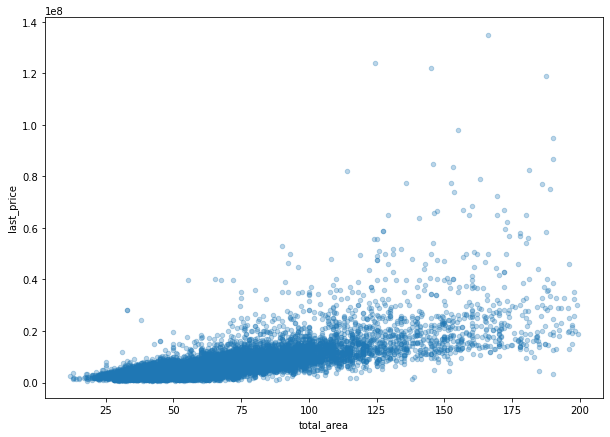

In [119]:
total_area_norm = data.query('total_area < 200 and last_price < 150000000')
total_area_norm.plot(y='last_price', x='total_area', kind='scatter', alpha = 0.3, figsize=(10, 7))

Коэффициент корреляции между ценой и плозадью квартиры высок, а на графике видна тенденция увеличения цены при увеличении площади

In [120]:
corrs.append(data['last_price'].corr(data['living_area']))
name.append('living_area')
data['last_price'].corr(data['living_area'])

0.5709837814621768

<AxesSubplot:xlabel='living_area', ylabel='last_price'>

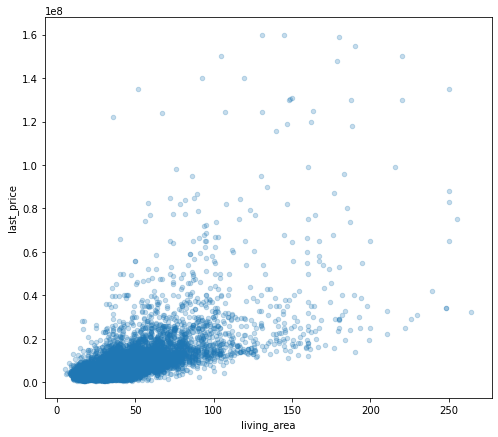

In [121]:
living_area_norm = data.query('living_area < 270 and last_price < 175000000')
living_area_norm.plot(x='living_area', y='last_price', kind='scatter', alpha=0.25, figsize=(8, 7))

Коэффициент корреляции меньше, но всё же она прослеживается и наблюдается такая же тенденция как и с предыдущим параметром.

In [122]:
corrs.append(data['last_price'].corr(data['kitchen_area']))
name.append('kitchen_area')
data['last_price'].corr(data['kitchen_area'])

0.47542275882640156

<AxesSubplot:xlabel='kitchen_area', ylabel='last_price'>

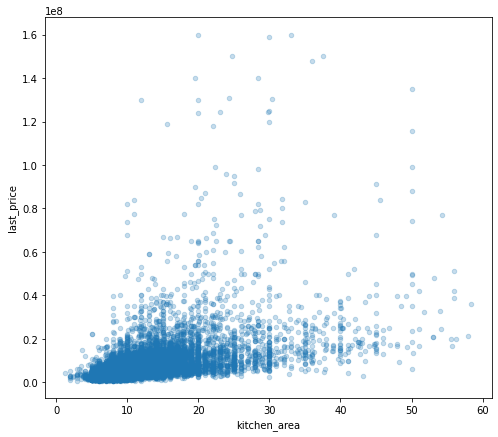

In [123]:
kitchen_area_norm = data.query('kitchen_area < 60 and last_price < 175000000')
kitchen_area_norm.plot(x='kitchen_area', y='last_price', kind='scatter', alpha=0.25, figsize=(8, 7))

Корреляция прослеживается ещё меньше, но есть. Скорее всего здесь такой эффект - чем больше кухня, тем больше квартира, чем больше квартира, тем больше цена, однако так бывает не всегда, поэтому и коэффициент меньше.

In [124]:
corrs.append(data['last_price'].corr(data['rooms']))
name.append('rooms')
data['last_price'].corr(data['rooms'])

0.3641715540950306

<AxesSubplot:xlabel='rooms', ylabel='last_price'>

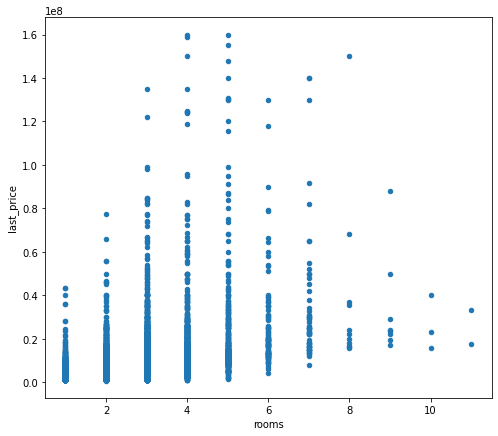

In [125]:
rooms_norm = data.query('rooms < 12 and last_price < 175000000')
rooms_norm.plot(x='rooms', y='last_price', kind='scatter', figsize=(8, 7))

Корреляция практически незаметна, дорогими бывают как 2-х комнатные так и 7 комнатные квартиры.

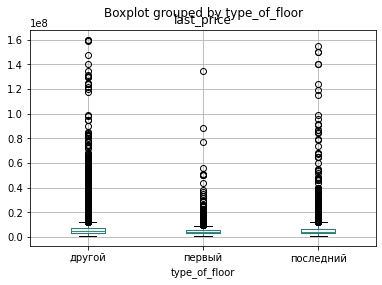

In [126]:
price_norm = data.query('last_price < 175000000')
price_norm.boxplot(column=['last_price'], by='type_of_floor');

Корреляции нет, кроме того факта, что квартиры на первом этаже стоят дешевле чем, на других.

<AxesSubplot:title={'center':'last_price'}, xlabel='weekday_exposition'>

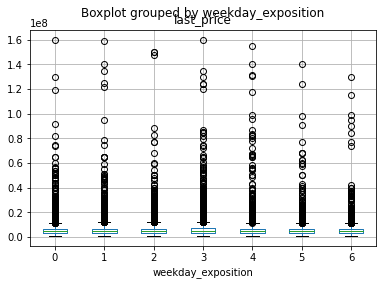

In [127]:
corrs.append(data['last_price'].corr(data['weekday_exposition']))
name.append('weekday_exposition')
price_norm = data.query('last_price < 175000000')
price_norm.boxplot(column=['last_price'], by='weekday_exposition')

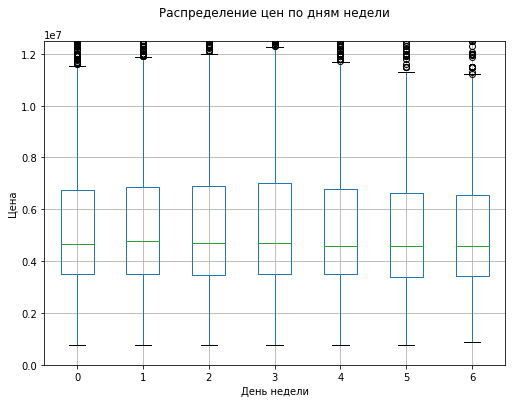

In [152]:
# код ревьюера
price_norm.boxplot(column=['last_price'], by='weekday_exposition', figsize=(8,6))
plt.suptitle('Распределение цен по дням недели')
plt.title('')
plt.ylim(0, 12500000)
plt.xlabel('День недели')
plt.ylabel('Цена')
plt.show()

Цена не зависит от дня публикации объявления

In [130]:
corrs.append(data['last_price'].corr(data['month_exposition']))
name.append('month_exposition')
data['last_price'].corr(data['month_exposition'])

0.0028926100323912415

<AxesSubplot:title={'center':'last_price'}, xlabel='month_exposition'>

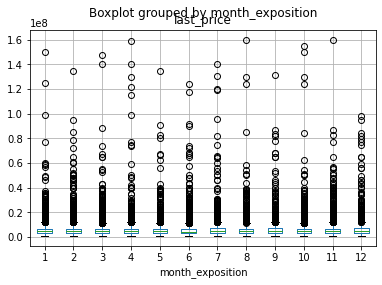

In [131]:
price_norm = data.query('last_price < 175000000')
price_norm.boxplot(column=['last_price'], by='month_exposition')

Корреляции совсем не наблюдается

<AxesSubplot:title={'center':'last_price'}, xlabel='year_exposition'>

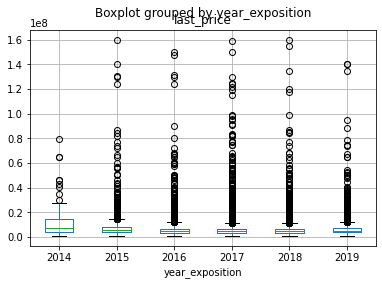

In [132]:
corrs.append(data['last_price'].corr(data['year_exposition']))
name.append('year_exposition')
price_norm = data.query('last_price < 175000000')
price_norm.boxplot(column=['last_price'], by='year_exposition')

После 2014 года либо квартиры стали дороже, либо в 2014 году дорогие квартиры не продавали

In [133]:
d = {'name': name, 'corr': corrs}
corelations = pd.DataFrame(data=d)
corelations

,name,corr
0,total_area,0.652785
1,living_area,0.570984
2,kitchen_area,0.475423
3,rooms,0.364172
4,weekday_exposition,0.002566
5,month_exposition,0.002893
6,year_exposition,-0.042245


#### 

In [134]:
top_10_mean = data.pivot_table(index='locality_name', values='price_1_square_metr', aggfunc=['mean', 'count'])
top_10_mean.columns = ['mean', 'count']
top_10_mean = top_10_mean.sort_values(by='count', ascending=False).head(10)
top_10_mean['mean'] = top_10_mean['mean'].astype(int)
top_10_mean

,mean,count
locality_name,,
Санкт-Петербург,114741,15598
Мурино,85371,560
Кудрово,95151,450
поселок Шушары,78405,436
Всеволожск,68683,391
Пушкин,103125,369
Колпино,75424,338
поселок Парголово,90289,323
Гатчина,68746,307


Цена квадратного метра в топ-10 пригородов Петербурга(включая сам Петербург) по количеству объявлений

In [135]:
high_sqm = top_10_mean.sort_values(by='mean', ascending=False).head()
high_sqm

,mean,count
locality_name,,
Санкт-Петербург,114741,15598
Пушкин,103125,369
Кудрово,95151,450
поселок Парголово,90289,323
Мурино,85371,560


Населённые пункты с самым дорогим квадратным метром

In [136]:
min_sqm = top_10_mean.sort_values(by='mean').head()
min_sqm

,mean,count
locality_name,,
Выборг,58554,233
Всеволожск,68683,391
Гатчина,68746,307
Колпино,75424,338
поселок Шушары,78405,436


Населённые пункты с самым дешёвым квадратным метром

#### 


In [137]:
only_peter = data.query('locality_name == "Санкт-Петербург"')
only_peter_table = only_peter.pivot_table(index='city_center_km', values='last_price', aggfunc='mean')
only_peter_table

,last_price
city_center_km,
0,2.344232e+07
1,1.889542e+07
2,1.625193e+07
3,1.347805e+07
4,1.365259e+07
5,1.528189e+07
6,1.458486e+07
7,1.286959e+07
8,8.731755e+06


<AxesSubplot:xlabel='city_center_km'>

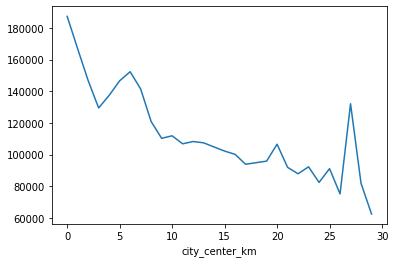

In [138]:
only_peter_mean =  only_peter.groupby(by='city_center_km')['price_1_square_metr'].mean()
only_peter_mean.plot()

<AxesSubplot:xlabel='city_center_km'>

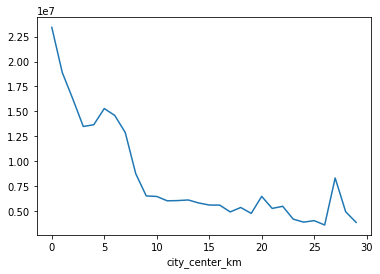

In [139]:
only_peter_mean =  only_peter.groupby(by='city_center_km')['last_price'].mean()
only_peter_mean.plot()

<AxesSubplot:xlabel='city_center_km'>

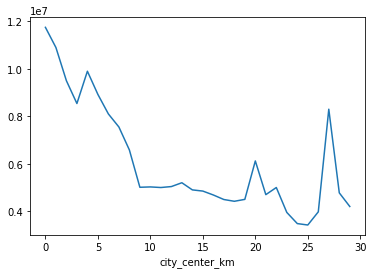

In [140]:
only_peter_mean =  only_peter.groupby(by='city_center_km')['last_price'].median()
only_peter_mean.plot()

На всех трёх графиках видна тенденция снижения стоимости как квартиры, так и квадратного метра по мере удаления от центра. Самые дорогие квартиры находятся в пределе 0-2 км от центра, потом цена снижается. Также есть вторая вершина на всех трёх графиков псоел 25 километров, возможно это связано с тем, что в этом радиусе расположены новые дорогие дома.

Вывод по этапу: На этом этапе были построены гистограммы по различным параметрам и рассмотрены их распределения, далее рассмотрено время продажи квартиры(менее 200 дней - быстрая продажа). Была найдена корреляция между параметрами и ценой квартиры. Самая большая корреляция цены с площадью квартиры и жилой площадью.Далее были рассмотрены цены на 1 квадратный метр в самых популярных районах. Найдёены самые дешёвые и дорогие населённые пункты. Самые дорогие - Петербург и Пушкин, дешёвый - Выборг. В конце составлены графики зависимости цены от удалённости от центра. Обнаружена зависимость - чем дальше от центра, тем дешевле квартира.

### Общий вывод

В начале работы над проектом были удалены или заменены пропущенные значения. На этом этапе было обнаружено, что в столбцах "ponds_around3000" и "parks_around3000" слишком много непонятных пропусков. Было решено их оставить. Далее были изменены типы данных в стобцах, удалены дубликаты и аномальные значения.
Затем были добавлены новые столбцы для дальнейшего изучения данных(цена квадратного метра, день, месяц, год публикации)

В исследовательском анализе данных всё началось с диаграмм. Были расмотрены различные параметры и выявлено несколько закономерностей. Например: была обнаружено, что на первом этаже продают очень много квартир.

Дальше следовало выяснение скорости продажи квартир


Быстрыми продажами мы стали считать продажи за менее чем 200 дней, так как большинство квартир в датасете было продано именно за этот промежуток.

В исследованиях корреляции сравнивалось несколько параметров с "last_price". Ниже представлена таблица итоговых результатов

In [141]:
corelations

,name,corr
0,total_area,0.652785
1,living_area,0.570984
2,kitchen_area,0.475423
3,rooms,0.364172
4,weekday_exposition,0.002566
5,month_exposition,0.002893
6,year_exposition,-0.042245


После корреляции были найдены топ-10 населённых пунктов по кол-ву выложенных объявлений и средняя стоимость квадратного метра в них. Также топ-5 самых дорогих и дешёвых населённых пункта по стоимости квадратного метра.

In [142]:
top_10_mean

,mean,count
locality_name,,
Санкт-Петербург,114741,15598
Мурино,85371,560
Кудрово,95151,450
поселок Шушары,78405,436
Всеволожск,68683,391
Пушкин,103125,369
Колпино,75424,338
поселок Парголово,90289,323
Гатчина,68746,307


In [143]:
high_sqm

,mean,count
locality_name,,
Санкт-Петербург,114741,15598
Пушкин,103125,369
Кудрово,95151,450
поселок Парголово,90289,323
Мурино,85371,560


In [144]:
min_sqm

,mean,count
locality_name,,
Выборг,58554,233
Всеволожск,68683,391
Гатчина,68746,307
Колпино,75424,338
поселок Шушары,78405,436


В финальном этапе работы мы составили несколько графиков распределения стоимости жилья по удалённости от центра Петербурга

<AxesSubplot:xlabel='city_center_km'>

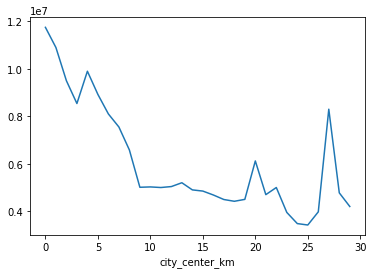

In [145]:
only_peter_mean.plot()

In [146]:
only_peter_table

,last_price
city_center_km,
0,2.344232e+07
1,1.889542e+07
2,1.625193e+07
3,1.347805e+07
4,1.365259e+07
5,1.528189e+07
6,1.458486e+07
7,1.286959e+07
8,8.731755e+06
